<a href="https://www.kaggle.com/code/suyashkumarbhagat/new-manuscript-test?scriptVersionId=239836336" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# import cv2
# import numpy as np
# import cupy as cp
# import cupy.cuda
# import time
# import concurrent.futures
# from PIL import Image

# def remove_small_components_gpu(image, min_size=250, gpu_id=0, invert=False):
#     """Processes an image on a specific GPU, with an option to remove small black or white specks."""
#     with cp.cuda.Device(gpu_id):  # Select GPU
#         image_gpu = cp.array(image, dtype=cp.uint8)

#         if invert:
#             image_gpu = 255 - image_gpu  # Invert for white speck removal

#         # Perform Connected Components Analysis on CPU
#         num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(cp.asnumpy(image_gpu), connectivity=8)

#         # Convert labels to CuPy array for GPU processing
#         labels_gpu = cp.array(labels)
#         output_gpu = cp.zeros_like(image_gpu)

#         # Keep only large components
#         for i in range(1, num_labels):
#             if stats[i, cv2.CC_STAT_AREA] >= min_size:
#                 output_gpu[labels_gpu == i] = 255

#         # Convert back to binary
#         final_result = 255 - output_gpu if invert else output_gpu

#         return cp.asnumpy(final_result)  # Move back to CPU

# # Load Image
# image = cv2.imread("/kaggle/input/manuscript-f-2/BISM-43/Scan_0017.tif", cv2.IMREAD_GRAYSCALE)

# # Split image into two halves for parallel processing
# height, width = image.shape
# top_half, bottom_half = image[:height // 2, :], image[height // 2:, :]

# start = time.time()

# # Run both denoising passes on different GPUs
# with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:
#     # First pass: Black speck removal (background cleaning)
#     future_top_black = executor.submit(remove_small_components_gpu, top_half, 250, 0, False)
#     future_bottom_black = executor.submit(remove_small_components_gpu, bottom_half, 250, 1, False)

#     denoised_top_black = future_top_black.result()
#     denoised_bottom_black = future_bottom_black.result()

#     # Merge results
#     denoised_black = np.vstack((denoised_top_black, denoised_bottom_black))

#     # Second pass: White speck removal (inside text)
#     future_top_white = executor.submit(remove_small_components_gpu, denoised_black[:height // 2, :], 5, 0, True)
#     future_bottom_white = executor.submit(remove_small_components_gpu, denoised_black[height // 2:, :], 5, 1, True)

#     denoised_top_white = future_top_white.result()
#     denoised_bottom_white = future_bottom_white.result()

#     # Merge results
#     final_denoised = np.vstack((denoised_top_white, denoised_bottom_white))

# end = time.time()

# # Convert to PIL Image for compression
# final_denoised = Image.fromarray(denoised_black)

# image_pil=final_denoised.resize((final_denoised.width // 2, final_denoised.height // 2), Image.LANCZOS)

# final_denoised_resized_np = np.array(image_pil)
# _, final_binarized = cv2.threshold(final_denoised_resized_np, 128, 1, cv2.THRESH_BINARY)

# # Convert binarized image back to PIL for saving
# final_binarized_pil = Image.fromarray(final_binarized)  # Multiply by 255 for saving as 0-255 range



# final_binarized_pil.save("/kaggle/working/compressed_resized.png", optimize=True)


# print(f"Multi-GPU Execution Time: {end - start:.4f} seconds")



In [12]:
! pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-rq39exw8
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-rq39exw8
  Resolved https://github.com/tensorflow/examples.git to commit fed63294c10c71b7da028e0e75de9ff68ac56d17
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1741282361.1454860421494433302046033067432040489300359736599-py3-none-any.whl size=301643 sha256=eccd6d2cf5b07f1137d5cf00e1a2d320cbcf1c3607b9a02816737b9177276cec
  Stored in directory: /tmp/pip-ephem-wheel-cache-f8sb_h0g/wheels/72/5f/d0/7fe769eaa229bf20101d11a357eb23c83c481bee2d7f710599
Successfully built tensorflow-examples


In [2]:
import cv2
import numpy as np
import cupy as cp
import cupy.cuda
import time
import concurrent.futures
from PIL import Image
import os
from skimage.metrics import peak_signal_noise_ratio, structural_similarity, mean_squared_error

def calculate_fsim(img1, img2):
    """
    Calculate Feature Similarity Index Method (FSIM) between two images.
    FSIM focuses on low-level features that are important for human perception.
    """
    # Convert images to float
    img1 = img1.astype(np.float32)
    img2 = img2.astype(np.float32)
    
    # Calculate gradients using Sobel operators
    sobelx1 = cv2.Sobel(img1, cv2.CV_32F, 1, 0, ksize=3)
    sobely1 = cv2.Sobel(img1, cv2.CV_32F, 0, 1, ksize=3)
    sobelx2 = cv2.Sobel(img2, cv2.CV_32F, 1, 0, ksize=3)
    sobely2 = cv2.Sobel(img2, cv2.CV_32F, 0, 1, ksize=3)
    
    # Calculate gradient magnitude
    mag1 = np.sqrt(sobelx1**2 + sobely1**2)
    mag2 = np.sqrt(sobelx2**2 + sobely2**2)
    
    # Calculate similarity of gradient magnitude
    T1 = 0.85  # Constant used in the FSIM paper
    Gm = (2 * mag1 * mag2 + T1) / (mag1**2 + mag2**2 + T1)
    
    # Since we're working with binary images, we'll use gradient magnitude as weights
    weights = (mag1 + mag2) / 2
    
    # Calculate FSIM
    fsim_value = np.sum(Gm * weights) / np.sum(weights) if np.sum(weights) > 0 else 0
    
    return fsim_value

def remove_small_components_gpu(image, min_size=250, gpu_id=0, invert=False):
    """Processes an image on a specific GPU, with an option to remove small black or white specks."""
    with cp.cuda.Device(gpu_id):  # Select GPU
        image_gpu = cp.array(image, dtype=cp.uint8)

        if invert:
            image_gpu = 255 - image_gpu  # Invert for white speck removal

        # Perform Connected Components Analysis on CPU
        num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(cp.asnumpy(image_gpu), connectivity=8)

        # Convert labels to CuPy array for GPU processing
        labels_gpu = cp.array(labels)
        output_gpu = cp.zeros_like(image_gpu)

        # Keep only large components
        for i in range(1, num_labels):
            if stats[i, cv2.CC_STAT_AREA] >= min_size:
                output_gpu[labels_gpu == i] = 255

        # Convert back to binary
        final_result = 255 - output_gpu if invert else output_gpu

        return cp.asnumpy(final_result)  # Move back to CPU

# Create output directory
output_dir = "/kaggle/output/denoised_manuscripts"
os.makedirs(output_dir, exist_ok=True)

# Load Image
image = cv2.imread("/kaggle/input/manuscript-f-2/BISM-43/Scan_0017.tif", cv2.IMREAD_GRAYSCALE)

# Split image into two halves for parallel processing
height, width = image.shape
top_half, bottom_half = image[:height // 2, :], image[height // 2:, :]

start = time.time()

# Run both denoising passes on different GPUs
with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:
    # First pass: Black speck removal (background cleaning)
    future_top_black = executor.submit(remove_small_components_gpu, top_half, 250, 0, False)
    future_bottom_black = executor.submit(remove_small_components_gpu, bottom_half, 250, 1, False)

    denoised_top_black = future_top_black.result()
    denoised_bottom_black = future_bottom_black.result()

    # Merge results
    final_denoised = np.vstack((denoised_top_black, denoised_bottom_black))

    # # Second pass: White speck removal (inside text)
    # future_top_white = executor.submit(remove_small_components_gpu, denoised_black[:height // 2, :], 5, 0, True)
    # future_bottom_white = executor.submit(remove_small_components_gpu, denoised_black[height // 2:, :], 5, 1, True)

    # denoised_top_white = future_top_white.result()
    # denoised_bottom_white = future_bottom_white.result()

    # # Merge results
    # final_denoised = np.vstack((denoised_top_white, denoised_bottom_white))

end = time.time()

# Convert to PIL Image for saving (no resizing)
final_denoised_pil = Image.fromarray(final_denoised)

# Apply thresholding to ensure binary image (255 instead of 1 for proper display)
final_denoised_np = np.array(final_denoised_pil)
_, final_binarized = cv2.threshold(final_denoised_np, 128, 255, cv2.THRESH_BINARY)

# Calculate image cleaning metrics
try:
    # PSNR (Peak Signal-to-Noise Ratio)
    psnr = peak_signal_noise_ratio(image, final_binarized)
    
    # SSIM (Structural Similarity Index)
    ssim = structural_similarity(image, final_binarized)
    
    # MSE (Mean Squared Error)
    mse = mean_squared_error(image, final_binarized)
    
    # FSIM (Feature Similarity Index Method)
    fsim_value = calculate_fsim(image, final_binarized)
    
    # Print metrics
    print(f"Image Cleaning Metrics:")
    print(f"PSNR: {psnr:.2f} dB")
    print(f"SSIM: {ssim:.4f}")
    print(f"MSE: {mse:.2f}")
    print(f"FSIM: {fsim_value:.4f}")
except Exception as e:
    print(f"Error calculating metrics: {e}")

# Save the final image to the designated output folder
output_path = os.path.join(output_dir, "denoised_Scan_0017.png")
cv2.imwrite(output_path, final_binarized)


print(f"Multi-GPU Execution Time: {end - start:.4f} seconds")
print(f"Denoised image saved to: {output_path}")


Image Cleaning Metrics:
PSNR: 29.75 dB
SSIM: 0.9927
MSE: 68.91
FSIM: 0.9656
Multi-GPU Execution Time: 4.5137 seconds
Denoised image saved to: /kaggle/output/denoised_manuscripts/denoised_Scan_0017.png


In [58]:
# import os
# from pathlib import Path
# from PIL import Image
# import shutil
# import tensorflow as tf 

# # Define source directories
# source_dir = Path('/kaggle/input/manuscript-testdnoised-cleaned/Bism P-2')
# denoised_dir = source_dir / 'Denoised'  # Contains .tif images
# cleaned_dir = source_dir / 'Cleaned'   # Contains .jpg images

# # Define target directory structure
# output_dir = Path('/kaggle/working/paired_dataset')
# train_dir = output_dir / 'train'
# test_dir = output_dir / 'test'

# # Create train/test directories with subfolders for paired images
# for subfolder in ['train/denoised', 'train/cleaned', 'test/denoised', 'test/cleaned']:
#     (output_dir / subfolder).mkdir(parents=True, exist_ok=True)

# # Get sorted lists of denoised and cleaned files
# denoised_files = sorted(denoised_dir.glob("*.tif"))
# cleaned_files = sorted(cleaned_dir.glob("*.jpg"))

# # Verify matching filename stems (case-insensitive)
# denoised_map = {f.stem.lower(): f for f in denoised_files}
# cleaned_map = {f.stem.lower(): f for f in cleaned_files}
# common_stems = set(denoised_map.keys()) & set(cleaned_map.keys())

# # Split into train/test (80% train, 20% test)
# split_idx = int(len(common_stems) * 0.875)
# train_stems = list(common_stems)[:split_idx]
# test_stems = list(common_stems)[split_idx:]

# def convert_to_jpg(input_path, output_path):
#     """Convert image to JPG format."""
#     with Image.open(input_path) as img:
#         img = img.convert("RGB")  # Ensure RGB format for JPG
#         img.save(output_path, "JPEG")

# # Copy and convert files to the new folder structure
# def copy_and_convert_images(stems, target_subfolder):
#     """Copy and convert paired images to the target folder."""
#     for stem in stems:
#         # Paths for denoised and cleaned files
#         denoised_src = denoised_map[stem]
#         cleaned_src = cleaned_map[stem]
        
#         # Target paths for converted files
#         denoised_dst = output_dir / f"{target_subfolder}/denoised/{stem}.jpg"
#         cleaned_dst = output_dir / f"{target_subfolder}/cleaned/{stem}.jpg"
        
#         # Convert to JPG format and save
#         convert_to_jpg(denoised_src, denoised_dst)
#         shutil.copy(cleaned_src, cleaned_dst)  # Cleaned images are already in JPG format
        
#         print(f"Copied: {denoised_src.name} → {denoised_dst}")
#         print(f"Copied: {cleaned_src.name} → {cleaned_dst}")

# # Process train and test sets
# copy_and_convert_images(train_stems, "train")
# copy_and_convert_images(test_stems, "test")

# print(f"Dataset creation complete!")
# print(f"Training pairs: {len(train_stems)}")
# print(f"Testing pairs: {len(test_stems)}")


In [57]:
import os
from pathlib import Path
from PIL import Image
import shutil

# Define source directories
source_dir = Path('/kaggle/input/manuscript-testdnoised-cleaned/Bism P-2')
denoised_dir = source_dir / 'Denoised'  # Contains .tif images
cleaned_dir = source_dir / 'Cleaned'   # Contains .jpg images

# Define target directory structure
output_dir = Path('/kaggle/working/paired_dataset')
train_dir = output_dir / 'train'
test_dir = output_dir / 'test'

# Create train/test directories with subfolders for paired images
for subfolder in ['train/denoised', 'train/cleaned', 'test/denoised', 'test/cleaned']:
    (output_dir / subfolder).mkdir(parents=True, exist_ok=True)

# Get sorted lists of denoised and cleaned files
denoised_files = sorted(denoised_dir.glob("*.tif"))
cleaned_files = sorted(cleaned_dir.glob("*.jpg"))

# Verify matching filename stems (case-insensitive)
denoised_map = {f.stem.lower(): f for f in denoised_files}
cleaned_map = {f.stem.lower(): f for f in cleaned_files}
common_stems = set(denoised_map.keys()) & set(cleaned_map.keys())

# Split into train/test (80% train, 20% test)
split_idx = int(len(common_stems) * 0.875)
train_stems = list(common_stems)[:split_idx]
test_stems = list(common_stems)[split_idx:]

def convert_to_jpg(input_path, output_path):
    """Convert image to JPG format."""
    with Image.open(input_path) as img:
        img = img.convert("RGB")  # Ensure RGB format for JPG
        img.save(output_path, "JPEG")

def apply_augmentations(image):
    """Apply horizontal and vertical flipping and return augmented images."""
    flipped_horiz = image.transpose(Image.FLIP_LEFT_RIGHT)
    flipped_vert = image.transpose(Image.FLIP_TOP_BOTTOM)
    return [flipped_horiz, flipped_vert]

# Copy, convert, and augment images
def copy_and_augment_images(stems, target_subfolder):
    """Copy, convert, and augment paired images to the target folder."""
    for stem in stems:
        # Paths for denoised and cleaned files
        denoised_src = denoised_map[stem]
        cleaned_src = cleaned_map[stem]
        
        # Target paths for original images
        denoised_dst = output_dir / f"{target_subfolder}/denoised/{stem}.jpg"
        cleaned_dst = output_dir / f"{target_subfolder}/cleaned/{stem}.jpg"
        
        # Convert denoised image to JPG and save
        convert_to_jpg(denoised_src, denoised_dst)
        shutil.copy(cleaned_src, cleaned_dst)  # Cleaned images are already in JPG format
        
        # Load images for augmentation
        denoised_img = Image.open(denoised_dst)
        cleaned_img = Image.open(cleaned_dst)

        # Apply augmentations
        augmented_denoised = apply_augmentations(denoised_img)
        augmented_cleaned = apply_augmentations(cleaned_img)

        # Save augmented images
        for i, (aug_denoised, aug_cleaned) in enumerate(zip(augmented_denoised, augmented_cleaned), start=1):
            denoised_aug_dst = output_dir / f"{target_subfolder}/denoised/{stem}_aug{i}.jpg"
            cleaned_aug_dst = output_dir / f"{target_subfolder}/cleaned/{stem}_aug{i}.jpg"
            
            aug_denoised.save(denoised_aug_dst, "JPEG")
            aug_cleaned.save(cleaned_aug_dst, "JPEG")

            print(f"Augmented: {denoised_aug_dst.name} and {cleaned_aug_dst.name}")

        print(f"Copied: {denoised_src.name} → {denoised_dst}")
        print(f"Copied: {cleaned_src.name} → {cleaned_dst}")

# Process train and test sets
copy_and_augment_images(train_stems, "train")
copy_and_augment_images(test_stems, "test")

print(f"Dataset creation complete!")
print(f"Training pairs (original): {len(train_stems)}")
print(f"Training pairs (with augmentation): {len(train_stems) * 3}")
print(f"Testing pairs: {len(test_stems)}")


Augmented: scan_0010_aug1.jpg and scan_0010_aug1.jpg
Augmented: scan_0010_aug2.jpg and scan_0010_aug2.jpg
Copied: Scan_0010.tif → /kaggle/working/paired_dataset/train/denoised/scan_0010.jpg
Copied: Scan_0010.jpg → /kaggle/working/paired_dataset/train/cleaned/scan_0010.jpg
Augmented: scan_0015_aug1.jpg and scan_0015_aug1.jpg
Augmented: scan_0015_aug2.jpg and scan_0015_aug2.jpg
Copied: Scan_0015.tif → /kaggle/working/paired_dataset/train/denoised/scan_0015.jpg
Copied: Scan_0015.jpg → /kaggle/working/paired_dataset/train/cleaned/scan_0015.jpg
Augmented: scan_0011_aug1.jpg and scan_0011_aug1.jpg
Augmented: scan_0011_aug2.jpg and scan_0011_aug2.jpg
Copied: Scan_0011.tif → /kaggle/working/paired_dataset/train/denoised/scan_0011.jpg
Copied: Scan_0011.jpg → /kaggle/working/paired_dataset/train/cleaned/scan_0011.jpg
Augmented: scan_0012_aug1.jpg and scan_0012_aug1.jpg
Augmented: scan_0012_aug2.jpg and scan_0012_aug2.jpg
Copied: Scan_0012.tif → /kaggle/working/paired_dataset/train/denoised/scan_

In [59]:
def load_image(image_path, target_size=(1024, 1024)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=1)  # Decode as a single-channel grayscale image
    image = tf.image.resize(image, target_size)  # Resize to target dimensions
    image = tf.tile(image, [1, 1, 3])  # Copy the single channel into three channels (R=G=B)
    image = (image / 127.5) - 1  # Normalize to [-1, 1]
    return image

def load_dataset(directory, target_size=(1024, 1024)):
    high_light_dir = os.path.join(directory, 'denoised')
    low_light_dir = os.path.join(directory, 'cleaned')
    
    high_light_images = [os.path.join(high_light_dir, img) for img in os.listdir(high_light_dir)]
    low_light_images = [os.path.join(low_light_dir, img) for img in os.listdir(low_light_dir)]
    
    high_light_dataset = tf.data.Dataset.from_tensor_slices(high_light_images)
    low_light_dataset = tf.data.Dataset.from_tensor_slices(low_light_images)
    
    high_light_dataset = high_light_dataset.map(lambda x: load_image(x, target_size))
    low_light_dataset = low_light_dataset.map(lambda x: load_image(x, target_size))
    
    return high_light_dataset, low_light_dataset


In [60]:
train_dir = '/kaggle/working/paired_dataset/train'
val_dir = '/kaggle/working/paired_dataset/test'

train_high_light_dataset, train_low_light_dataset = load_dataset(train_dir)
val_high_light_dataset, val_low_light_dataset = load_dataset(val_dir)

# Combine high and low light datasets
train_dataset = tf.data.Dataset.zip((train_low_light_dataset, train_high_light_dataset))
val_dataset = tf.data.Dataset.zip((val_low_light_dataset, val_high_light_dataset))

# Optional: Shuffle and batch the datasets
batch_size = 1

train_dataset = train_dataset.shuffle(buffer_size=100).batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

In [61]:
print(len(train_dataset))
print(len(val_dataset))

45
9


In [62]:
import tensorflow_examples
from tensorflow_examples.models.pix2pix import pix2pix

In [63]:
OUTPUT_CHANNELS = 3

G= pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
F = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

D_X = pix2pix.discriminator(norm_type='instancenorm', target=False)
D_Y = pix2pix.discriminator(norm_type='instancenorm', target=False)

In [64]:
F.summary()
D_X.summary()

Model: "functional_111"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_92            │ (None, None, None, 3)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_87             │ (None, None, None, 64) │          3,072 │ input_layer_92[0][0]   │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_88             │ (None, None, None,     │        131,328 │ sequential_87[0][0]    │
│ (Sequential)              │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_89             │ (None, None, None,     │        524,800 │ sequential_88[0][0]    │
│ (Sequential)              │ 256)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_90             │ (None, None, None,     │      2,098,176 │ sequential_89[0][0]    │
│ (Sequential)              │ 512)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_91             │ (None, None, None,     │      4,195,328 │ sequential_90[0][0]    │
│ (Sequential)              │ 512)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_92             │ (None, None, None,     │      4,195,328 │ sequential_91[0][0]    │
│ (Sequential)              │ 512)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_93             │ (None, None, None,     │      4,195,328 │ sequential_92[0][0]    │
│ (Sequential)              │ 512)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_94             │ (None, None, None,     │      4,195,328 │ sequential_93[0][0]    │
│ (Sequential)              │ 512)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_95             │ (None, None, None,     │      4,195,328 │ sequential_94[0][0]    │
│ (Sequential)              │ 512)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_5             │ (None, None, None,     │              0 │ sequential_95[0][0],   │
│ (Concatenate)             │ 128)                   │                │ sequential_93[0][0],   │
│                           │                        │                │ sequential_96[0][0],   │
│                           │                        │                │ sequential_92[0][0],   │
│                           │                        │                │ sequential_97[0][0],   │
│                           │                        │                │ sequential_91[0][0],   │
│                           │                        │                │ sequential_98[0][0],   │
│                           │                        │                │ sequential_90[0][0],   │
│                      

 Total params: 54,414,979 (207.58 MB)

 Trainable params: 54,414,979 (207.58 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_115"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_102 (Sequential)          │ (None, None, None, 64)      │           3,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_103 (Sequential)          │ (None, None, None, 128)     │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_104 (Sequential)          │ (None, None, None, 256)     │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ zero_padding2d_8 (ZeroPadding2D)     │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_71 (Conv2D)                   │ (None, None, None, 512)     │       2,097,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ instance_normalization_98            │ (None, None, None, 512)     │           1,024 │
│ (InstanceNormalization)              │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_67 (LeakyReLU)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ zero_padding2d_9 (ZeroPadding2D)     │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_72 (Conv2D)                   │ (None, None, None, 1)       │           8,193 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,765,569 (10.55 MB)

 Trainable params: 2,765,569 (10.55 MB)

 Non-trainable params: 0 (0.00 B)

In [65]:
from tensorflow.keras.optimizers import Adam

# Loss functions
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

def cycle_consistency_loss(real_image, cycled_image, lambda_cycle):
    return lambda_cycle * tf.reduce_mean(tf.abs(real_image - cycled_image))

def identity_loss(real_image, same_image, lambda_identity):
    return lambda_identity * 0.5 * tf.reduce_mean(tf.abs(real_image - same_image))

In [66]:
# Optimizers
generator_g_optimizer = Adam(1e-3,beta_1=0.4)
generator_f_optimizer = Adam(2e-3,beta_1=0.6)
discriminator_x_optimizer = Adam(2e-2,beta_1=0.8)
discriminator_y_optimizer = Adam(2e-2,beta_1=0.8)

In [67]:
# Training step function
gen_g_losses=[]
gen_f_losses=[]
disc_x_losses=[]
disc_y_losses=[]

@tf.function
def train_step(real_x, real_y, G, F, D_X, D_Y, lambda_cycle, lambda_identity):
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X to Y
        fake_y = G(real_x, training=True)
        # Generator F translates Y to X
        fake_x = F(real_y, training=True)

        # Cycle consistency
        cycled_x = F(fake_y, training=True)
        cycled_y = G(fake_x, training=True)

        # Identity mapping
        same_x = F(real_x, training=True)
        same_y = G(real_y, training=True)

        # Discriminator output
        disc_real_x = D_X(real_x, training=True)
        disc_real_y = D_Y(real_y, training=True)
        disc_fake_x = D_X(fake_x, training=True)
        disc_fake_y = D_Y(fake_y, training=True)

        # Calculate the losses
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        cycle_loss_g = cycle_consistency_loss(real_x, cycled_x, lambda_cycle)
        cycle_loss_f = cycle_consistency_loss(real_y, cycled_y, lambda_cycle)

        identity_loss_g = identity_loss(real_y, same_y, lambda_identity)
        identity_loss_f = identity_loss(real_x, same_x, lambda_identity)

        total_gen_g_loss = gen_g_loss + cycle_loss_g + identity_loss_g
        total_gen_f_loss = gen_f_loss + cycle_loss_f + identity_loss_f

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Calculate the gradients
    gradients_of_generator_g = tape.gradient(total_gen_g_loss, G.trainable_variables)
    gradients_of_generator_f = tape.gradient(total_gen_f_loss, F.trainable_variables)

    gradients_of_discriminator_x = tape.gradient(disc_x_loss, D_X.trainable_variables)
    gradients_of_discriminator_y = tape.gradient(disc_y_loss, D_Y.trainable_variables)

    # Apply the gradients to the optimizers
    generator_g_optimizer.apply_gradients(zip(gradients_of_generator_g, G.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(gradients_of_generator_f, F.trainable_variables))

    discriminator_x_optimizer.apply_gradients(zip(gradients_of_discriminator_x, D_X.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(gradients_of_discriminator_y, D_Y.trainable_variables))

    return total_gen_g_loss, total_gen_f_loss, disc_x_loss, disc_y_loss

In [68]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [69]:
val_high_images=list(val_high_light_dataset.as_numpy_iterator())
val_low_images=list(val_low_light_dataset.as_numpy_iterator())

example_real_x=val_low_images[2]
example_real_y=val_high_images[2]

In [70]:
def denormalize_image(image):
    """Convert an image from [-1, 1] to [0, 1] for visualization."""
    return (image + 1.0) / 2.0

def plot_generated_images(generator,input_image,title):
    generated_image=generator(tf.expand_dims(input_image,0),training=False)[0]
    
    input_image=denormalize_image(input_image)
    generated_image=denormalize_image(generated_image)
    
    plt.imshow(np.hstack([input_image,generated_image]))
    plt.title(title)
    plt.axis('off')
    plt.show()

In [71]:
def loss_plot(gen_g_losses,gen_f_losses,disc_x_losses,disc_y_losses,epoch):
    plt.figure(figsize=(10,5))
    plt.plot(gen_g_losses,label='Generator G Loss')
    plt.plot(gen_f_losses,label='Generator F Loss')
    plt.plot(disc_x_losses,label='Discriminator X Loss')
    plt.plot(disc_y_losses,label='Discriminator Y Loss')
    
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Generator and Discriminator Losses')
    plt.legend()
    plt.grid(True)
    
    plt.show()

Epoch 15/15
Generator G Loss: 0.9430436491966248, Generator F Loss: 1.2698345184326172
Discriminator X Loss: 0.6845895051956177, Discriminator Y Loss: 0.6197802424430847


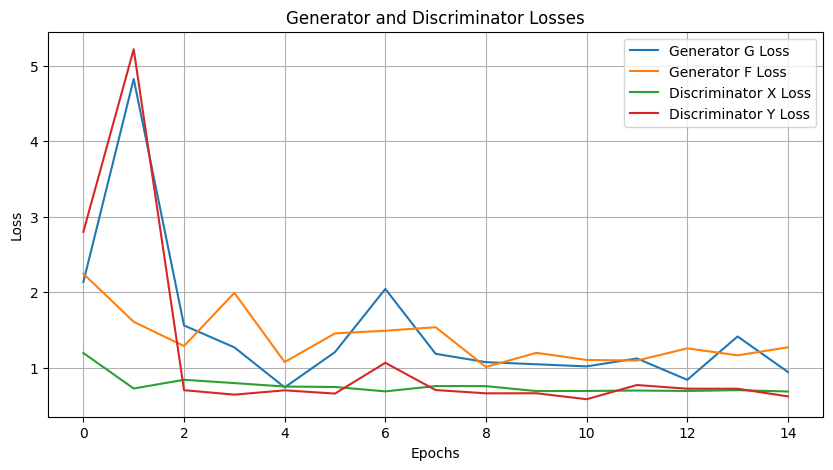

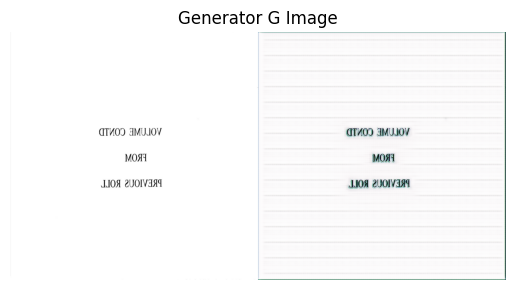

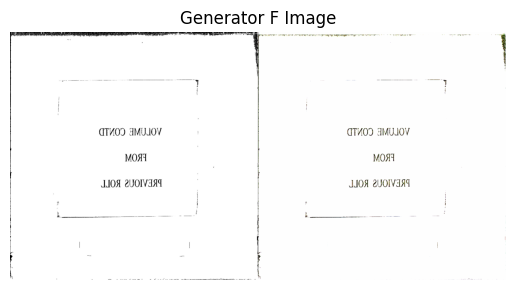

In [72]:
epochs = 15
lambda_cycle = 5.0
lambda_identity = 0.5


for epoch in range(epochs):
    clear_output(wait=True)
    
    for real_x, real_y in train_dataset:
        total_gen_g_loss, total_gen_f_loss, disc_x_loss, disc_y_loss = train_step(real_x, real_y, G, F, D_X, D_Y, lambda_cycle=5.0, lambda_identity=0.5)
    
    gen_g_losses.append(total_gen_g_loss.numpy())
    gen_f_losses.append(total_gen_f_loss.numpy())
    disc_x_losses.append(disc_x_loss.numpy())
    disc_y_losses.append(disc_y_loss.numpy())
    
    print(f'Epoch {epoch + 1}/{epochs}')
    print(f'Generator G Loss: {total_gen_g_loss}, Generator F Loss: {total_gen_f_loss}')
    print(f'Discriminator X Loss: {disc_x_loss}, Discriminator Y Loss: {disc_y_loss}')
    
    loss_plot(gen_g_losses,gen_f_losses,disc_x_losses,disc_y_losses,epoch)
    
    plot_generated_images(G,example_real_x,'Generator G Image')
    plot_generated_images(F,example_real_y,'Generator F Image')

In [101]:
def compute_metrics(input_image, generated_image):
    """ Compute PSNR, SSIM, MSE, and FSIM between input and generated images. """

    # Convert TensorFlow tensor to NumPy array (if needed)
    if isinstance(generated_image, tf.Tensor):
        generated_image = generated_image.numpy()

    # Convert images to uint8 (0-255) format
    input_image = (input_image * 255).astype(np.uint8)
    generated_image = (generated_image * 255).astype(np.uint8)

    # Convert to grayscale for SSIM & FSIM
    input_gray = cv2.cvtColor(input_image, cv2.COLOR_RGB2GRAY)
    generated_gray = cv2.cvtColor(generated_image, cv2.COLOR_RGB2GRAY)

    # Compute Metrics
    psnr_value = cv2.PSNR(input_image, generated_image)
    ssim_value = ssim(input_gray, generated_gray, data_range=255)
    mse_value = mse(input_image, generated_image)
    fsim_value = calculate_fsim(input_image, generated_image)  # FSIM Calculation

    return psnr_value, ssim_value, mse_value, fsim_value
import tensorflow as tf
import numpy as np

def compute_metrics_new(input_image, generated_image):
    """Compute PSNR, SSIM, MSE, and FSIM metrics."""
    # Convert TensorFlow tensors to NumPy arrays if needed
    if isinstance(input_image, tf.Tensor):
        input_image = input_image.numpy()
    if isinstance(generated_image, tf.Tensor):
        generated_image = generated_image.numpy()
    
    # Convert images to uint8 (0-255) format
    input_image = (input_image * 255).astype(np.uint8)
    generated_image = (generated_image * 255).astype(np.uint8)

    # Compute metrics (Assuming your metric functions exist)
    psnr_value = cv2.PSNR(input_image, generated_image)
    #ssim_value = ssim(input_image, generated_image, data_range=255)
    mse_value = mse(input_image, generated_image)
    fsim_value = calculate_fsim(input_image, generated_image)

    return psnr_value, mse_value, fsim_value


In [76]:
def plot_generated_test_images(generator,input_image,title):
    generated_image=generator(tf.expand_dims(input_image,0),training=False)[0]
    
    input_image=denormalize_image(input_image)
    generated_image=denormalize_image(generated_image)
    psnr,ssim, mse,fsim_value=compute_metrics(input_image, generated_image)
    
    plt.imshow(np.hstack([input_image,generated_image]))
    plt.title(title)
    plt.axis('off')
    plt.show()
    print(f"Image Cleaning Metrics:")
    print(f"PSNR: {psnr:.2f} dB")
    print(f"SSIM: {ssim:.4f}")
    print(f"MSE: {mse:.2f}")
    print(f"FSIM: {fsim_value:.4f}")

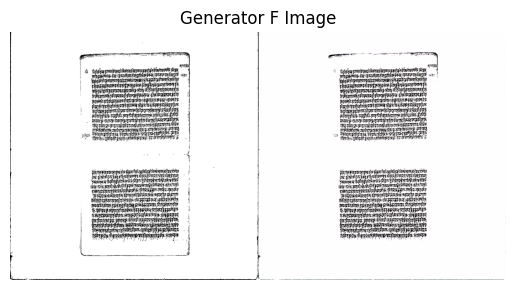

Image Cleaning Metrics:
PSNR: 20.02 dB
SSIM: 0.9594
MSE: 10.52
FSIM: 0.9656


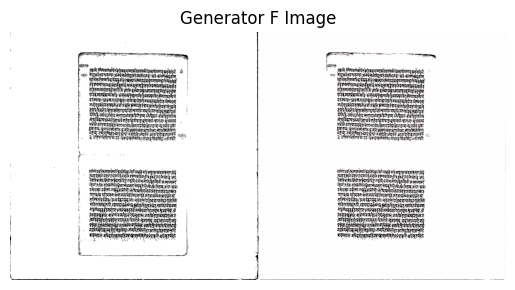

Image Cleaning Metrics:
PSNR: 19.25 dB
SSIM: 0.9575
MSE: 9.44
FSIM: 0.9656


In [80]:
#example_real_x=val_low_images[3]
example_real_y=val_high_images[8]
#plot_generated_test_images(G,example_real_x,'Generator G Image')
plot_generated_test_images(F,example_real_y,'Generator F Image')
example_real_2=val_high_images[4]
plot_generated_test_images(F,example_real_2,'Generator F Image')

In [ ]:
def load_image(image_path, target_size=(1024, 1024)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=1)  # Decode as a single-channel grayscale image
    image = tf.image.resize(image, target_size)  # Resize to target dimensions
    image = tf.tile(image, [1, 1, 3])  # Copy the single channel into three channels (R=G=B)
    image = (image / 127.5) - 1  # Normalize to [-1, 1]
    return image

Image saved at: /kaggle/working/new/new.jpg
Image Cleaning Metrics after CCA:
PSNR: 21.21 dB
MSE: 11.09
FSIM: 0.9320


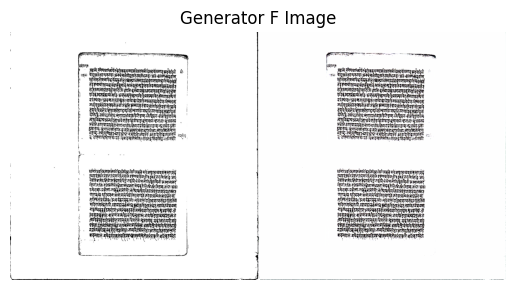

Image Cleaning Metrics:
PSNR: 19.25 dB
SSIM: 0.9575
MSE: 9.44
FSIM: 0.9656


In [103]:
import os
from PIL import Image

new_image_path = '/kaggle/input/manuscript-f-2/BISM-43/Scan_0009.tif'
output_dir = '/kaggle/working/new/'  # Directory path
output_path = os.path.join(output_dir, 'new.jpg')  # Full path to output file

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)  # Only create the directory

# Convert and save the image
with Image.open(new_image_path) as img:
    img = img.convert("RGB")  # Ensure RGB format for JPG
    img.save(output_path, "JPEG")

print(f"Image saved at: {output_path}")

new_img=load_image(output_path)
psnr1, mse1,fsim_value1=compute_metrics_new(new_img, example_real_2)
print(f"Image Cleaning Metrics after CCA:")
print(f"PSNR: {psnr1:.2f} dB")
#print(f"SSIM: {ssim1:.4f}")
print(f"MSE: {mse1:.2f}")
print(f"FSIM: {fsim_value1:.4f}")

plot_generated_test_images(F,example_real_2,'Generator F Image')



In [108]:
generated_image=F(tf.expand_dims(example_real_2,0),training=False)[0]
input_image=denormalize_image(new_img)
generated_image=denormalize_image(generated_image)
psnr1, mse1,fsim_value1=compute_metrics_new(new_img, generated_image)
print(f"Image Cleaning Metrics after CCA:")
print(f"PSNR: {psnr1:.2f} dB")
#print(f"SSIM: {ssim1:.4f}")
print(f"MSE: {mse1:.2f}")
print(f"FSIM: {fsim_value1:.4f}")

Image Cleaning Metrics after CCA:
PSNR: 17.66 dB
MSE: 11.39
FSIM: 0.8755
